<a href="https://colab.research.google.com/github/teoad95/Deep-learning-Cryptocurrency-price-prediction/blob/main/Etherium_prediction_thodoris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [38]:
# get market info for bitcoin from the start of 2016 to the current day
eth_market_info = pd.read_csv('EthereumDataset.csv')
eth_market_info.index

RangeIndex(start=0, stop=2088, step=1)

In [39]:
eth_market_info = eth_market_info.dropna(how='any',axis=0) 
eth_market_info.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087],
           dtype='int64', length=2084)

In [40]:
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# when Volume is equal to '-' convert it to 0
eth_market_info.loc[eth_market_info['Volume']=="-",'Volume']=0
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
eth_market_info.columns = eth_market_info.columns.str.replace("*", "")

In [41]:
eth_market_info

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,1.643290e+05
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,6.741880e+05
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,5.321700e+05
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,4.052830e+05
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1.463100e+06
...,...,...,...,...,...,...,...
2083,2021-04-20,2161.939453,2345.834961,2060.143799,2330.210938,2330.210938,3.943348e+10
2084,2021-04-21,2331.160156,2467.200684,2238.366943,2364.751709,2364.751709,3.889907e+10
2085,2021-04-22,2357.871094,2641.094971,2315.960205,2403.535156,2403.535156,5.357590e+10
2086,2021-04-23,2401.256348,2439.537109,2117.039551,2363.586182,2363.586182,5.541393e+10


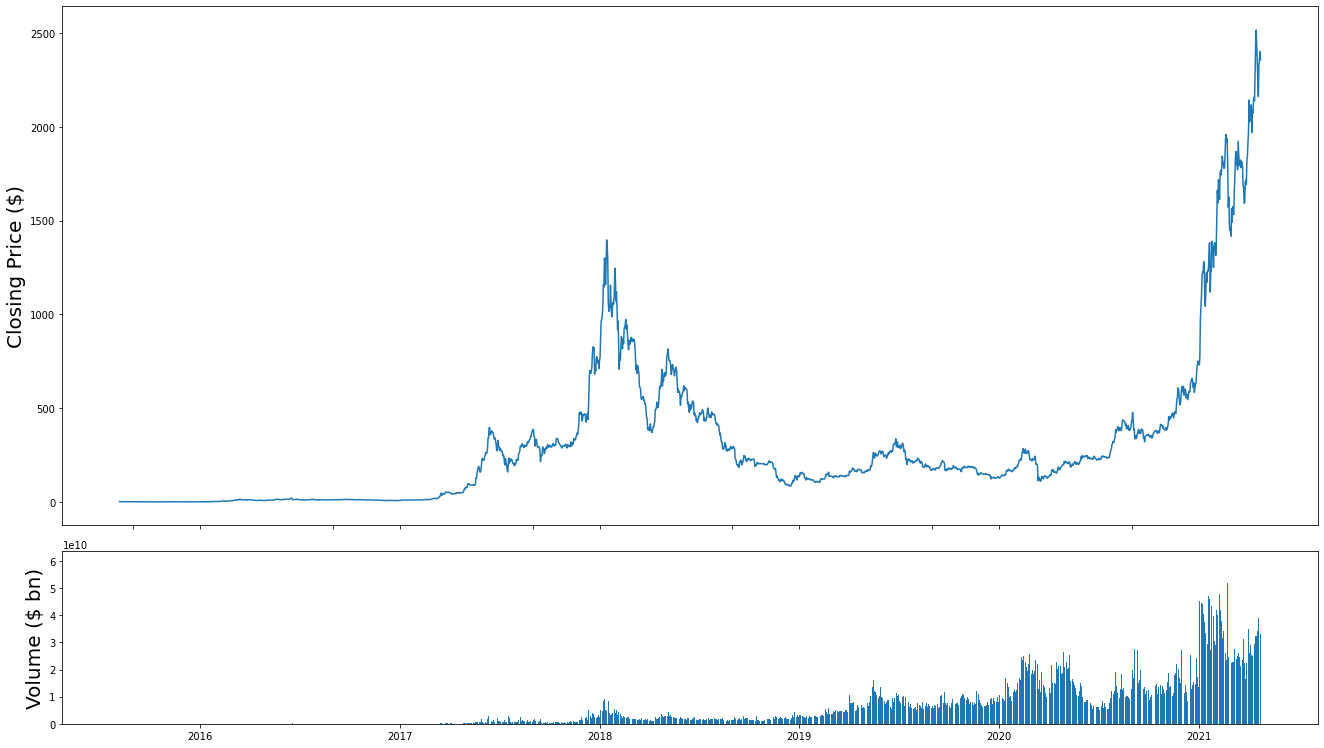

In [42]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=20)
ax2.set_ylabel('Volume ($ bn)',fontsize=20)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax1.set_xticklabels('')
ax1.plot(eth_market_info['Date'],eth_market_info['Open'])
ax2.bar(eth_market_info['Date'], eth_market_info['Volume'].values)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

plt.show()

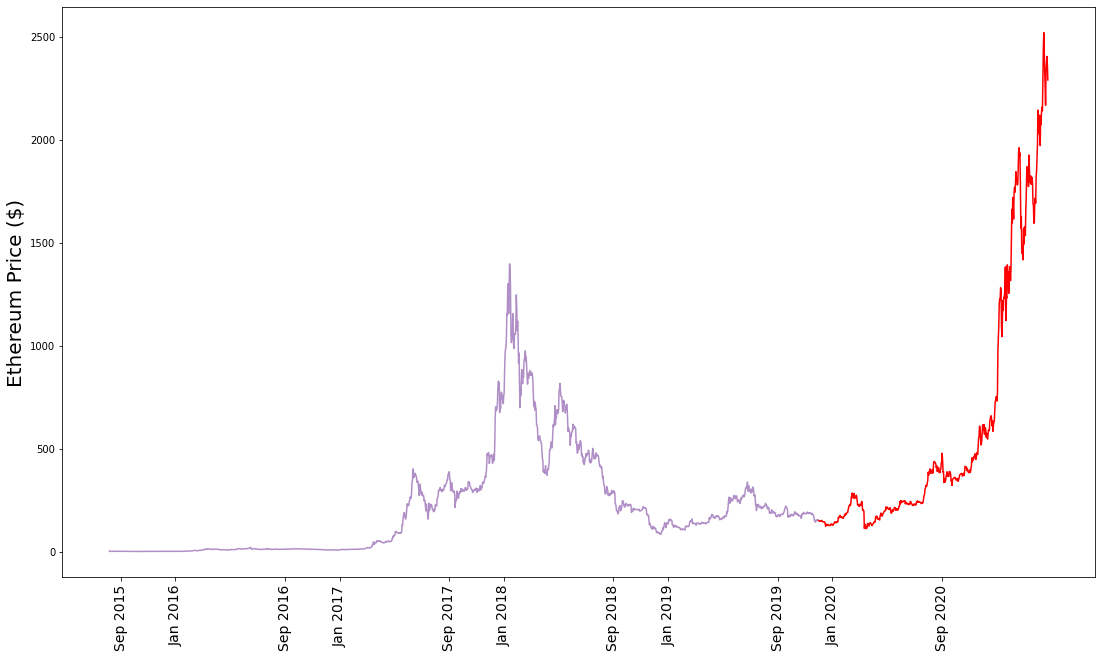

In [43]:
split_date = '2019-12-01'
fig, (ax2) = plt.subplots(1,1)
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,9]])
ax2.plot(eth_market_info[eth_market_info['Date'] < split_date]['Date'],
         eth_market_info[eth_market_info['Date'] < split_date]['Close'], 
         color='#B08FC7')
ax2.plot(eth_market_info[eth_market_info['Date'] >= split_date]['Date'],
         eth_market_info[eth_market_info['Date'] >= split_date]['Close'], color='red')
ax2.set_ylabel('Ethereum Price ($)',fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.xticks(fontsize=14, rotation=90)
plt.show()

In [44]:
kwargs = {'day_diff': lambda x: (x['Close']-x['Open'])/x['Open'],
          'close_off_high': lambda x: 2*(x['High']- x['Close'])/(x['High']-x['Low'])-1,
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
eth_market_info = eth_market_info.assign(**kwargs)

In [45]:
model_data = eth_market_info.sort_values(by='Date')
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [46]:
window_len = 10

In [47]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

In [48]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

In [49]:
LSTM_training_inputs[0]

,Open,High,Low,Close,Adj Close,Volume,day_diff,close_off_high,volatility
0,2.831620,3.536610,2.521120,0.000000,2.772120,0.000000,-0.021013,0.505657,0.358625
1,2.793760,2.798810,0.714725,-0.728249,0.753325,3.102672,-0.730354,0.962957,0.745979
2,0.706136,0.879810,0.629191,-0.746801,0.701897,2.238442,-0.006003,0.419789,0.354916
3,0.713989,0.729854,0.636546,-0.744438,0.708448,1.466290,-0.007761,-0.541175,0.130685
4,0.708087,1.131410,0.663235,-0.614786,1.067860,7.903480,0.508092,-0.728520,0.661183
5,1.058750,1.289940,0.883608,-0.560827,1.217440,12.087282,0.149884,-0.643149,0.383785
6,1.222240,1.965070,1.171990,-0.340696,1.827670,23.759355,0.495345,-0.653503,0.648874
7,1.810920,2.261880,1.754750,-0.340624,1.827870,27.217965,0.009360,0.711632,0.280040
8,1.802890,1.877240,1.570980,-0.390755,1.688900,14.544183,-0.063226,0.229935,0.169872
9,1.684350,1.695240,1.089810,-0.435079,1.566030,20.607811,-0.070247,-0.573163,0.359444


In [50]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [51]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [52]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
1567/1567 - 5s - loss: 0.2426
Epoch 2/50
1567/1567 - 3s - loss: 0.1591
Epoch 3/50
1567/1567 - 3s - loss: 0.1533
Epoch 4/50
1567/1567 - 3s - loss: 0.1504
Epoch 5/50
1567/1567 - 3s - loss: 0.1537
Epoch 6/50
1567/1567 - 3s - loss: 0.1455
Epoch 7/50
1567/1567 - 3s - loss: 0.1476
Epoch 8/50
1567/1567 - 3s - loss: 0.1427
Epoch 9/50
1567/1567 - 3s - loss: 0.1398
Epoch 10/50
1567/1567 - 3s - loss: 0.1388
Epoch 11/50
1567/1567 - 3s - loss: 0.1403
Epoch 12/50
1567/1567 - 4s - loss: 0.1344
Epoch 13/50
1567/1567 - 3s - loss: 0.1337
Epoch 14/50
1567/1567 - 3s - loss: 0.1393
Epoch 15/50
1567/1567 - 3s - loss: 0.1351
Epoch 16/50
1567/1567 - 3s - loss: 0.1430
Epoch 17/50
1567/1567 - 3s - loss: 0.1367
Epoch 18/50
1567/1567 - 3s - loss: 0.1389
Epoch 19/50
1567/1567 - 3s - loss: 0.1356
Epoch 20/50
1567/1567 - 3s - loss: 0.1346
Epoch 21/50
1567/1567 - 3s - loss: 0.1384
Epoch 22/50
1567/1567 - 3s - loss: 0.1399
Epoch 23/50
1567/1567 - 3s - loss: 0.1399
Epoch 24/50
1567/1567 - 3s - loss: 0.1451
E

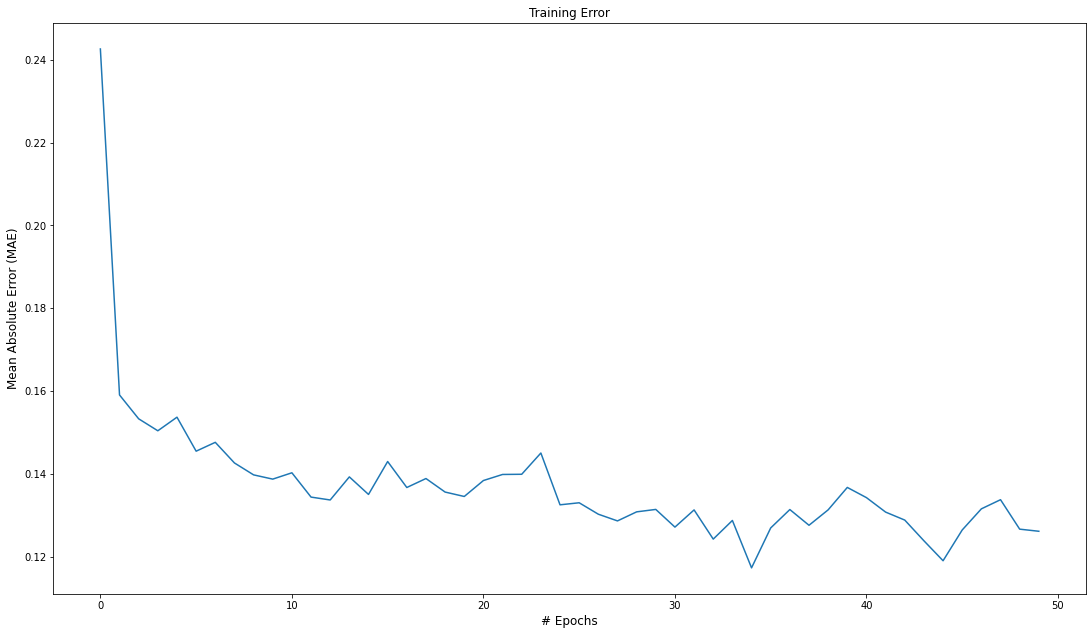

In [53]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
fig.set_size_inches(18.5, 10.5)
plt.show()

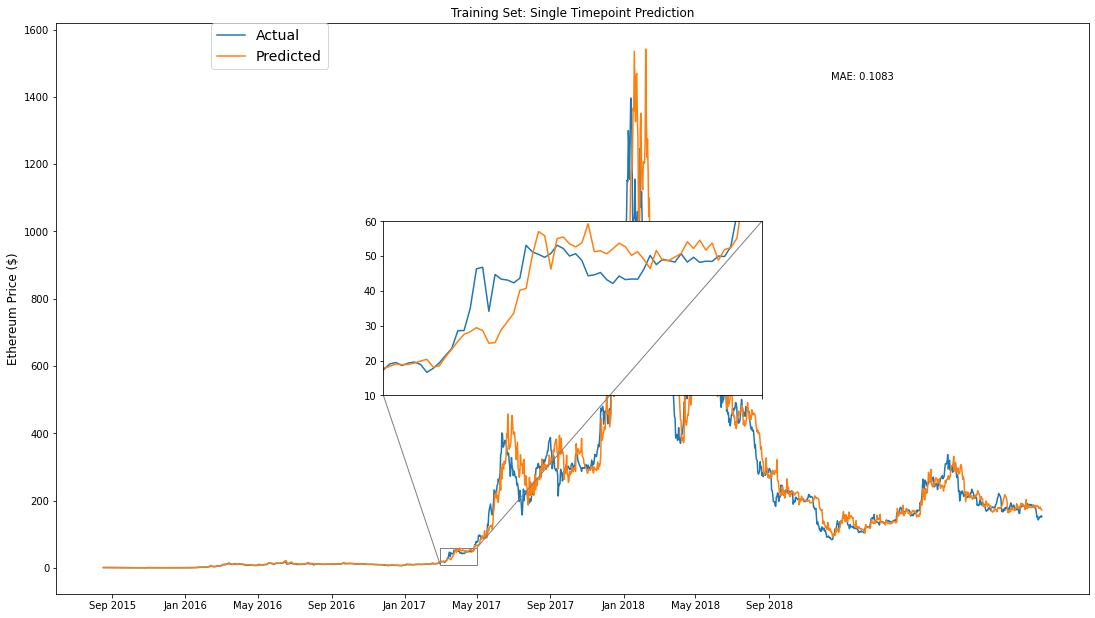

In [55]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         training_set['Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['Close'].values[window_len:])/(training_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 10.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         training_set['Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
fig.set_size_inches(18.5, 10.5)
plt.show()


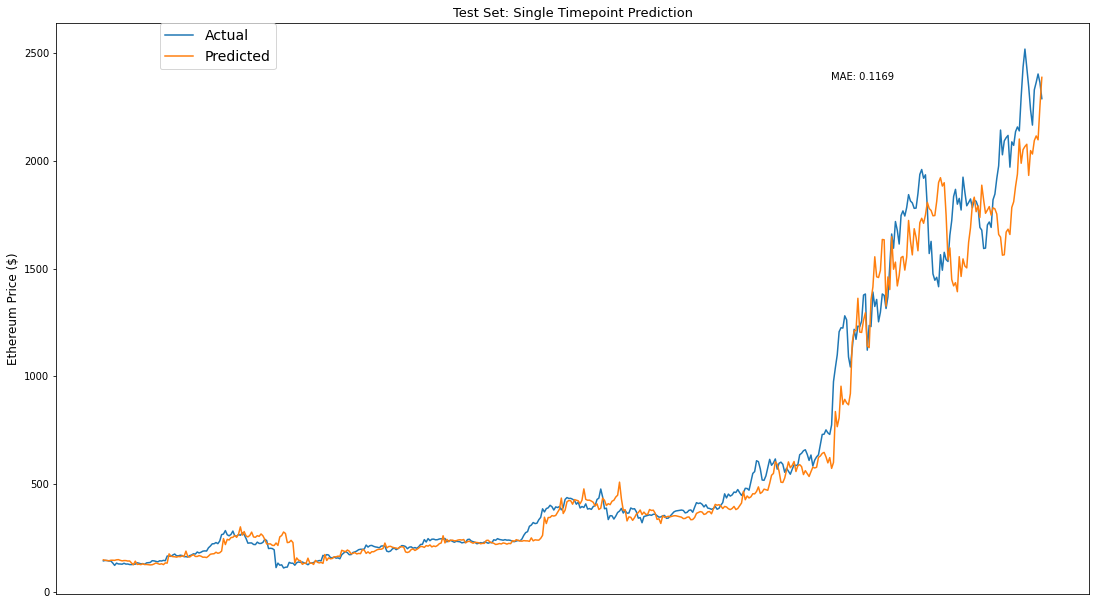

In [56]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['Close'].values[window_len:])/(test_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.set_size_inches(18.5, 10.5)
plt.show()

[148.38221115]


ValueError: ignored

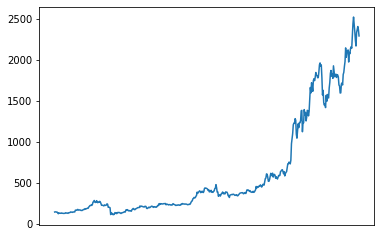

In [75]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax2) = plt.subplots(1,1)

ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['Close'][window_len:], label='Actual')
for i, eth_pred in enumerate(eth_pred_prices):
    print(eth_pred)
    # Only adding lines to the legend once
    if i<5:
        ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:((i*pred_range)+pred_range)],
                 eth_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:i*pred_range+pred_range],
                 eth_pred, color=pred_colors[i%5])
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
fig.tight_layout()
plt.show()

In [61]:
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

In [62]:
eth_pred_prices

array([[ 148.38221115],
       [ 146.51478452],
       [ 143.56366273],
       [ 133.6732335 ],
       [ 126.10788732],
       [ 124.7729328 ],
       [ 127.83924104],
       [ 176.0002379 ],
       [ 163.85923303],
       [ 163.22153619],
       [ 164.02192619],
       [ 158.96213862],
       [ 183.67562068],
       [ 219.20055713],
       [ 261.6227258 ],
       [ 279.56494368],
       [ 254.74414187],
       [ 260.1002242 ],
       [ 215.76570009],
       [ 261.19111393],
       [ 238.86982982],
       [ 144.57492888],
       [ 132.46827821],
       [ 134.04125316],
       [ 157.26290386],
       [ 165.65317634],
       [ 188.5895504 ],
       [ 178.24956452],
       [ 185.51759031],
       [ 195.91910294],
       [ 203.61982298],
       [ 202.92354192],
       [ 185.06962636],
       [ 191.86820869],
       [ 206.12668127],
       [ 212.68769126],
       [ 260.15898857],
       [ 239.71792645],
       [ 240.17733776],
       [ 229.66837808],
       [ 222.83881533],
       [ 231.208